![header](images/header.jpg)

# Multiple Linear Regression Model
## King County, WA

**Authors:** Ilan Haskel, Jonathan Fetterolf, Nate Kist

# Overview
|||

# Business Problem

Seattle Flippers, asked us to predict the prices of homes in the market so they can make
data driven decisions regarding potential houses to flip. Accurately modeling housing prices is incredibly important while flipping houses becuase the business is inherently risky and investors want to ensure a healthy return on investment. 

# Experimental Data Analyis

## About the Data
|||

### Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import stats as stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import jarque_bera
from statsmodels.compat import lzip

### Functions
Below are functions that are later used in the notebook.

In [2]:
def drop_outliers(df, col):
    q1 = df[col].quantile(.25)
    q3 = df[col].quantile(.75)
    iqr = q3 - q1

    lower_lim = q1 - 1.5 * iqr
    upper_lim = q3 + 1.5 * iqr

    df = df.loc[ (df[col] >= lower_lim) & (df[col] <= upper_lim) ].reset_index(drop=True)
    return df

def scale_numberical_cols(df, cols_to_scale):
    df = df.copy()
    features = cols_to_scale
    autoscaler = StandardScaler()
    df[features] = autoscaler.fit_transform(df[features])
    return df

### Importing Data

In [3]:
df = pd.read_csv('data/kc_house_data.csv')
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view',
       'condition', 'grade', 'heat_source', 'sewer_system', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'address', 'lat', 'long'],
      dtype='object')

In [4]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long
count,3.015500e+04,3.015500e+04,30155.000000,30155.000000,30155.000000,3.015500e+04,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000
mean,4.538104e+09,1.108536e+06,3.413530,2.334737,2112.424739,1.672360e+04,1.543492,1809.826098,476.039396,330.211142,217.412038,1975.163953,90.922301,47.328076,-121.317397
std,2.882587e+09,8.963857e+05,0.981612,0.889556,974.044318,6.038260e+04,0.567717,878.306131,579.631302,285.770536,245.302792,32.067362,416.473038,1.434005,5.725475
min,1.000055e+06,2.736000e+04,0.000000,0.000000,3.000000,4.020000e+02,1.000000,2.000000,0.000000,0.000000,0.000000,1900.000000,0.000000,21.274240,-157.791480
25%,2.064175e+09,6.480000e+05,3.000000,2.000000,1420.000000,4.850000e+03,1.000000,1180.000000,0.000000,0.000000,40.000000,1953.000000,0.000000,47.405320,-122.326045
50%,3.874011e+09,8.600000e+05,3.000000,2.500000,1920.000000,7.480000e+03,1.500000,1560.000000,0.000000,400.000000,150.000000,1977.000000,0.000000,47.551380,-122.225585
75%,7.287100e+09,1.300000e+06,4.000000,3.000000,2619.500000,1.057900e+04,2.000000,2270.000000,940.000000,510.000000,320.000000,2003.000000,0.000000,47.669913,-122.116205
max,9.904000e+09,3.075000e+07,13.000000,10.500000,15360.000000,3.253932e+06,4.000000,12660.000000,8020.000000,3580.000000,4370.000000,2022.000000,2022.000000,64.824070,-70.074340


### Drop Outliers 
(+ or - 1.5 * Interquartile Range)

In [5]:
df = drop_outliers(df, 'sqft_living').reset_index(drop=True)
df = drop_outliers(df, 'lat').reset_index(drop=True)
df = drop_outliers(df, 'long').reset_index(drop=True)
df = drop_outliers(df, 'price').reset_index(drop=True)
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long
count,2.644800e+04,2.644800e+04,26448.000000,26448.000000,26448.000000,2.644800e+04,26448.000000,26448.000000,26448.000000,26448.000000,26448.000000,26448.000000,26448.000000,26448.000000,26448.000000
mean,4.573990e+09,9.351912e+05,3.368232,2.224686,1974.694722,1.533174e+04,1.489394,1694.948994,455.235632,315.399009,196.672754,1972.578910,84.517733,47.538115,-122.226111
std,2.872331e+09,4.291522e+05,0.944539,0.784825,757.739880,5.288984e+04,0.546934,712.103736,541.989620,268.232397,221.044850,31.396284,402.133419,0.150044,0.129056
min,1.000055e+06,2.736000e+04,0.000000,0.000000,3.000000,4.020000e+02,1.000000,2.000000,0.000000,0.000000,0.000000,1900.000000,0.000000,47.000860,-122.526650
25%,2.144800e+09,6.250000e+05,3.000000,2.000000,1400.000000,4.900000e+03,1.000000,1160.000000,0.000000,0.000000,30.000000,1951.000000,0.000000,47.406360,-122.333720
50%,3.888100e+09,8.256500e+05,3.000000,2.500000,1870.000000,7.363000e+03,1.000000,1510.000000,0.000000,380.000000,130.000000,1974.000000,0.000000,47.550050,-122.257115
75%,7.298013e+09,1.190000e+06,4.000000,2.500000,2450.000000,1.013625e+04,2.000000,2110.000000,920.000000,500.000000,290.000000,1999.000000,0.000000,47.673410,-122.139277
max,9.904000e+09,2.230000e+06,11.000000,7.500000,4410.000000,3.067495e+06,4.000000,5500.000000,3560.000000,2840.000000,2880.000000,2022.000000,2022.000000,47.876700,-121.829060


### Finding & Dropping Nulls

In [6]:
df.isnull().sum().sum()

28

In [7]:
df = df.dropna().reset_index(drop=True)

In [8]:
df.isnull().sum().sum()

0

### Dropping Undesired Columns

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26420 entries, 0 to 26419
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             26420 non-null  int64  
 1   date           26420 non-null  object 
 2   price          26420 non-null  float64
 3   bedrooms       26420 non-null  int64  
 4   bathrooms      26420 non-null  float64
 5   sqft_living    26420 non-null  int64  
 6   sqft_lot       26420 non-null  int64  
 7   floors         26420 non-null  float64
 8   waterfront     26420 non-null  object 
 9   greenbelt      26420 non-null  object 
 10  nuisance       26420 non-null  object 
 11  view           26420 non-null  object 
 12  condition      26420 non-null  object 
 13  grade          26420 non-null  object 
 14  heat_source    26420 non-null  object 
 15  sewer_system   26420 non-null  object 
 16  sqft_above     26420 non-null  int64  
 17  sqft_basement  26420 non-null  int64  
 18  sqft_g

In [10]:
df = df.drop(['view', 
              'sqft_above',
              'sqft_basement', 
              'yr_renovated', 
              'id'
             ], axis=1)

### Extract ZIP Codes 
Extract only the 5 digit ZIP Code from each entry in the 'address' column.

In [11]:
df['zipcode'] = df.address.str[-20:-15]
df['zipcode'].value_counts()

98042    985
98038    853
98103    740
98117    731
98115    719
        ... 
98372      2
98296      1
98422      1
98050      1
98387      1
Name: zipcode, Length: 79, dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26420 entries, 0 to 26419
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          26420 non-null  object 
 1   price         26420 non-null  float64
 2   bedrooms      26420 non-null  int64  
 3   bathrooms     26420 non-null  float64
 4   sqft_living   26420 non-null  int64  
 5   sqft_lot      26420 non-null  int64  
 6   floors        26420 non-null  float64
 7   waterfront    26420 non-null  object 
 8   greenbelt     26420 non-null  object 
 9   nuisance      26420 non-null  object 
 10  condition     26420 non-null  object 
 11  grade         26420 non-null  object 
 12  heat_source   26420 non-null  object 
 13  sewer_system  26420 non-null  object 
 14  sqft_garage   26420 non-null  int64  
 15  sqft_patio    26420 non-null  int64  
 16  yr_built      26420 non-null  int64  
 17  address       26420 non-null  object 
 18  lat           26420 non-nu

### Add Age When Sold Feature
This can be found by subtracting the year the house was built from the year in which the house was sold.

In [13]:
df['date'].value_counts()
df['date_year'] = df['date'].apply(pd.to_datetime)
df['date_year'] = df['date_year'].dt.year
df['date_year']

df['age_when_sold'] = df['date_year'] - df['yr_built']
df['age_when_sold']

0         53
1         71
2         65
3         11
4          9
        ... 
26415    100
26416     10
26417     27
26418     16
26419     57
Name: age_when_sold, Length: 26420, dtype: int64

In [14]:
df['yr_built'].value_counts()

2021    1129
1968     482
1967     451
1978     450
1977     450
        ... 
1901      36
1935      35
1934      34
1902      31
1933      29
Name: yr_built, Length: 123, dtype: int64

In [15]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_garage,sqft_patio,yr_built,lat,long,date_year,age_when_sold
count,2.642000e+04,26420.000000,26420.000000,26420.000000,2.642000e+04,26420.000000,26420.000000,26420.000000,26420.000000,26420.000000,26420.000000,26420.000000,26420.000000
mean,9.354395e+05,3.369531,2.225360,1975.344928,1.524770e+04,1.489421,315.607419,196.662983,1972.573051,47.538172,-122.226127,2021.354996,48.781945
std,4.291241e+05,0.943124,0.784123,757.302280,5.227460e+04,0.547000,268.206900,220.967477,31.388103,0.150008,0.128973,0.478521,31.406812
min,2.736000e+04,0.000000,0.000000,3.000000,4.020000e+02,1.000000,0.000000,0.000000,1900.000000,47.000860,-122.526650,2021.000000,-1.000000
25%,6.250000e+05,3.000000,2.000000,1400.000000,4.900000e+03,1.000000,0.000000,30.000000,1951.000000,47.406434,-122.333679,2021.000000,22.000000
50%,8.260000e+05,3.000000,2.500000,1870.000000,7.360000e+03,1.000000,380.000000,130.000000,1974.000000,47.550115,-122.257115,2021.000000,47.000000
75%,1.190470e+06,4.000000,2.500000,2450.000000,1.013200e+04,2.000000,500.000000,290.000000,1999.000000,47.673411,-122.139277,2022.000000,70.000000
max,2.230000e+06,11.000000,7.500000,4410.000000,3.067495e+06,4.000000,2840.000000,2880.000000,2022.000000,47.876700,-121.829060,2022.000000,122.000000


### Checking Correlation

Find the most correlated column to price.

In [16]:
abs(df.corr()['price']).sort_values()

sqft_lot         0.060780
age_when_sold    0.073991
yr_built         0.075396
date_year        0.089280
long             0.145425
floors           0.209825
sqft_garage      0.216967
sqft_patio       0.233824
bedrooms         0.299602
bathrooms        0.418828
lat              0.440139
sqft_living      0.547406
price            1.000000
Name: price, dtype: float64

### EDA Visualizations
**Heatmap**

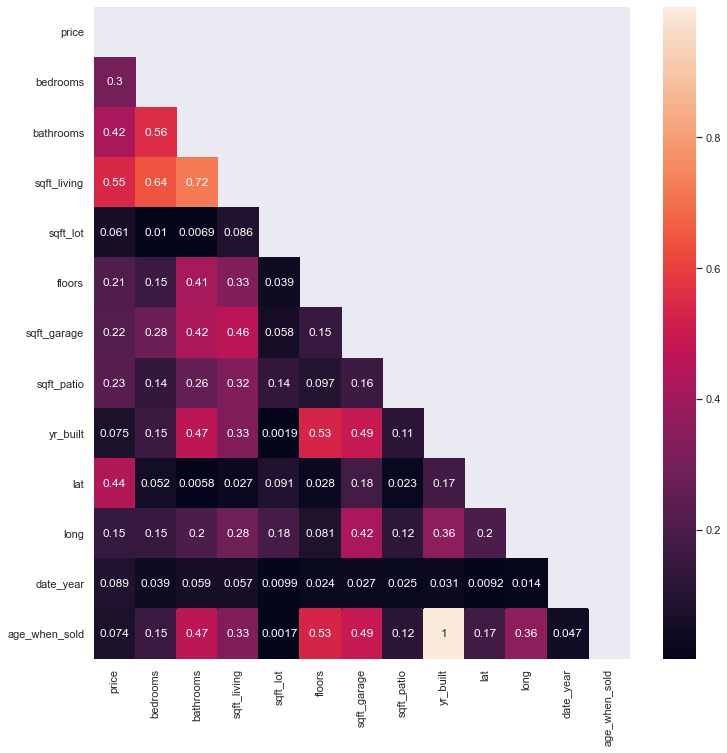

In [17]:
sns.set(rc={'figure.figsize':(12, 12)})

# Use the .heatmap function to depict the relationships visually!
mask  = np.triu(np.ones_like(df.corr()))
sns.heatmap(abs(df.corr()), annot=True, mask=mask);

In [19]:
#|||
#pairplot with wanted columns
#commented out for run-time

#sns.pairplot(df_colwanted)

**Log Scale Target**  -  ( Price )

<AxesSubplot:xlabel='price', ylabel='Count'>

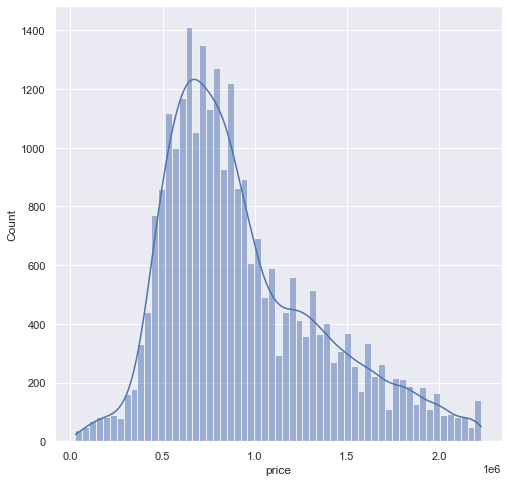

In [20]:
fig, ax = plt.subplots(figsize=(8,8))
sns.histplot(df.price, kde=True)

<AxesSubplot:xlabel='price', ylabel='Count'>

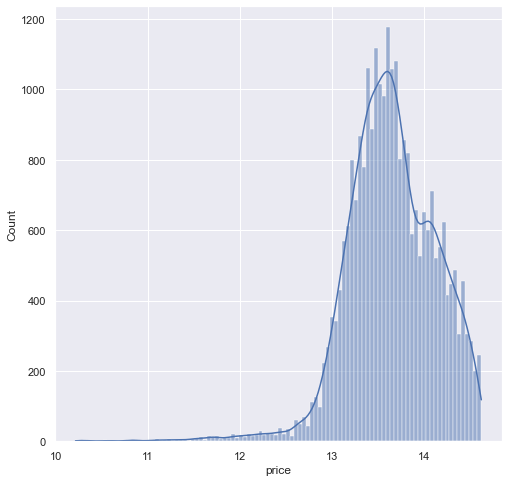

In [21]:
#logscaling target
fig, ax = plt.subplots(figsize=(8,8))
y2 = np.log(df.price)
sns.histplot(y2, kde=True)

# Baseline OLS Model - v1

In [22]:
x = sm.add_constant(df[['sqft_living', 'sqft_lot', 'sqft_patio']])
y = df['price']
model = sm.OLS(y, x).fit()
model.rsquared

0.3033787884100603

**Baseline Results**

In [23]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     3835.
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:18:34   Log-Likelihood:            -3.7537e+05
No. Observations:               26420   AIC:                         7.507e+05
Df Residuals:                   26416   BIC:                         7.508e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.212e+05   6158.583     52.150      0.000    3.09e+05    3.33e+05
sqft_living   298.3032      3.077     96.946      0.000     292.272     304.334
sqft_lot        0.0567      0.043      1.330      0.183      -0.027       0.140
sqft_patio    122.8036     10.605     11.580      0.000     102.017     143.590
==============================================================================
Omnibus:                     1260.728   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1501.723
Skew:                           0.524   Prob(JB):                         0.00
Kurtosis:                       3.518   Cond. No.                     1.52e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Log Scaled OLS Model

In [24]:
x = sm.add_constant(df[['sqft_living', 'sqft_lot', 'sqft_patio']])
y2 = np.log(df['price'])
model = sm.OLS(y2, x).fit()
model.rsquared

0.2552250673702846

**Log Scaled Model Results**

In [25]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     3017.
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:18:34   Log-Likelihood:                -14547.
No. Observations:               26420   AIC:                         2.910e+04
Df Residuals:                   26416   BIC:                         2.914e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          13.0027      0.007   1801.914      0.000      12.989      13.017
sqft_living     0.0003   3.61e-06     85.852      0.000       0.000       0.000
sqft_lot    -1.491e-08   4.99e-08     -0.299      0.765   -1.13e-07    8.29e-08
sqft_patio      0.0001   1.24e-05     10.947      0.000       0.000       0.000
==============================================================================
Omnibus:                     7865.705   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            50024.140
Skew:                          -1.279   Prob(JB):                         0.00
Kurtosis:                       9.237   Cond. No.                     1.52e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Log Scaled OLS

Dropping columns to address multicolinearity

In [26]:
x = sm.add_constant(df[['sqft_living', 'age_when_sold']])
y2 = np.log(df['price'])
model = sm.OLS(y2, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     4613.
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:18:34   Log-Likelihood:                -14483.
No. Observations:               26420   AIC:                         2.897e+04
Df Residuals:                   26417   BIC:                         2.900e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.9001      0.010   1323.135      0.000      12.881      12.919
sqft_living       0.0003    3.6e-06     94.668      0.000       0.000       0.000
age_when_sold     0.0014   8.69e-05     15.821      0.000       0.001       0.002
==============================================================================
Omnibus:                     8255.856   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            54761.444
Skew:                          -1.339   Prob(JB):                         0.00
Kurtosis:                       9.525   Cond. No.                     8.01e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Log Scaled OLS**

In [27]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     4613.
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:18:34   Log-Likelihood:                -14483.
No. Observations:               26420   AIC:                         2.897e+04
Df Residuals:                   26417   BIC:                         2.900e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.9001      0.010   1323.135      0.000      12.881      12.919
sqft_living       0.0003    3.6e-06     94.668      0.000       0.000       0.000
age_when_sold     0.0014   8.69e-05     15.821      0.000       0.001       0.002
==============================================================================
Omnibus:                     8255.856   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            54761.444
Skew:                          -1.339   Prob(JB):                         0.00
Kurtosis:                       9.525   Cond. No.                     8.01e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### OneHotEncoding

In [28]:
#0:number of baths
#1:number of bedrooms
#2:condition
#3:heat source

ohe = OneHotEncoder(drop='first')
ohe_cols = ['bathrooms', 
            'bedrooms', 
            'condition', 
            'heat_source']
ohe.fit(df[ohe_cols])
ohe_all = pd.DataFrame(ohe.transform(df[ohe_cols]).todense(),
                        columns=ohe.get_feature_names())
ohe_all
X_cat = pd.concat([x,ohe_all], axis=1)
X_cat.head(2)

,const,sqft_living,age_when_sold,x0_0.5,x0_1.0,x0_1.5,x0_2.0,x0_2.5,x0_3.0,x0_3.5,...,x2_Fair,x2_Good,x2_Poor,x2_Very Good,x3_Electricity/Solar,x3_Gas,x3_Gas/Solar,x3_Oil,x3_Oil/Solar,x3_Other
0,1.0,1180,53,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,2770,71,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [29]:
scaled_oheall_model = sm.OLS(y2, sm.add_constant(X_cat)).fit()
scaled_oheall_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     275.7
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:18:35   Log-Likelihood:                -14022.
No. Observations:               26420   AIC:                         2.812e+04
Df Residuals:                   26381   BIC:                         2.844e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   12.9547      0.089    145.085      0.000      12.780      13.130
sqft_living              0.0003   5.55e-06     55.419      0.000       0.000       0.000
age_when_sold            0.0023      0.000     21.710      0.000       0.002       0.003
x0_0.5                   0.5909      0.221      2.671      0.008       0.157       1.024
x0_1.0                   0.2748      0.122      2.245      0.025       0.035       0.515
x0_1.5                   0.3450      0.123      2.811      0.005       0.104       0.586
x0_2.0                   0.4315      0.122      3.524      0.000       0.191       0.671
x0_2.5                   0.5004      0.122      4.088      0.000       0.260       0.740
x0_3.0                   0.5180      0.123      4.227      0.000       0.278       0.758
x0_3.5                   0.6053      0.123      4.929      0.000       0.365       0.846
x0_4.0                   0.5792      0.124      4.671      0.000       0.336       0.822
x0_4.5                   0.5381      0.127      4.233      0.000       0.289       0.787
x0_5.0                   0.5092      0.140      3.637      0.000       0.235       0.784
x0_5.5                   0.2151      0.160      1.342      0.180      -0.099       0.529
x0_6.0                   0.6934      0.170      4.071      0.000       0.360       1.027
x0_6.5                   0.8769      0.268      3.270      0.001       0.351       1.403
x0_7.0                   0.6429      0.269      2.394      0.017       0.117       1.169
x0_7.5                   0.5191      0.325      1.597      0.110      -0.118       1.156
x1_1                    -0.3962      0.101     -3.928      0.000      -0.594      -0.199
x1_2                    -0.4282      0.099     -4.339      0.000      -0.622      -0.235
x1_3                    -0.5072      0.099     -5.140      0.000      -0.701      -0.314
x1_4                    -0.5495      0.099     -5.556      0.000      -0.743      -0.356
x1_5                    -0.6219      0.099     -6.258      0.000      -0.817      -0.427
x1_6                    -0.6685      0.101     -6.587      0.000      -0.867      -0.470
x1_7                    -0.7290      0.113     -6.437      0.000      -0.951      -0.507
x1_8                    -0.7374      0.125     -5.877      0.000      -0.983      -0.491
x1_9                    -0.6772      0.162     -4.175      0.000      -0.995      -0.359
x1_10                   -0.8362      0.486     -1.719      0.086      -1.789       0.117
x1_11                   -0.4058      0.424     -0.957      0.338      -1.237       0.425
x2_Fair                 -0.1156      0.029     -4.014      0.000      -0.172      -0.059
x2_Good                  0.0056      0.006      0.917      0.359      -0.006       0.018
x2_Poor                 -0.3029      0.054     -5.606    

### Scale Numerical Columns

In [30]:
df = scale_numberical_cols(df, ['sqft_living', 'age_when_sold', 'long', 'lat'])
df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,...,sewer_system,sqft_garage,sqft_patio,yr_built,address,lat,long,zipcode,date_year,age_when_sold
0,5/24/2022,675000.0,4,1.0,-1.050254,7140,1.0,NO,NO,NO,...,PUBLIC,0,40,1969,"2102 Southeast 21st Court, Renton, Washington ...",-0.507960,0.276085,98055,2022,0.134306
1,12/13/2021,920000.0,5,2.5,1.049343,6703,1.0,NO,NO,YES,...,PUBLIC,0,240,1950,"11231 Greenwood Avenue North, Seattle, Washing...",1.155646,-1.006297,98133,2021,0.707441
2,9/29/2021,311000.0,6,2.0,1.194599,6156,1.0,NO,NO,NO,...,PUBLIC,0,0,1956,"8504 South 113th Street, Seattle, Washington 9...",-0.240836,0.007187,98178,2021,0.516396
3,12/14/2021,775000.0,3,3.0,0.243837,1400,2.0,NO,NO,NO,...,PUBLIC,200,270,2010,"4079 Letitia Avenue South, Seattle, Washington...",0.186248,-0.496803,98118,2021,-1.203008
4,8/24/2021,592500.0,2,2.0,-1.129484,758,2.0,NO,NO,YES,...,PUBLIC,550,30,2012,"2193 Northwest Talus Drive, Issaquah, Washingt...",-0.038010,1.195983,98027,2021,-1.266690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26415,11/30/2021,1555000.0,5,2.0,-0.086288,4000,1.5,NO,NO,NO,...,PUBLIC,0,210,1921,"4673 Eastern Avenue North, Seattle, Washington...",0.843758,-0.800747,98103,2021,1.630825
26416,6/16/2021,1313000.0,3,2.0,0.058967,5800,2.0,NO,NO,NO,...,PUBLIC,0,520,2011,"4131 44th Avenue Southwest, Seattle, Washingto...",0.182915,-1.259068,98116,2021,-1.234849
26417,5/27/2022,800000.0,3,2.0,-0.469234,3600,1.0,NO,NO,YES,...,PUBLIC,240,110,1995,"910 Martin Luther King Jr Way, Seattle, Washin...",0.481471,-0.540611,98122,2022,-0.693555
26418,2/24/2022,775000.0,3,2.5,0.785243,2889,2.0,NO,NO,NO,...,PUBLIC,480,100,2006,"17127 114th Avenue Southeast, Renton, Washingt...",-0.591190,0.287250,98055,2022,-1.043804


In [31]:
ohe_cols = ['bathrooms', 
            'bedrooms', 
            'condition', 
            'heat_source']

ohe = OneHotEncoder(drop='first')
    
ohe.fit(df[ohe_cols])
ohe_all = pd.DataFrame(ohe.transform(df[ohe_cols]).todense(),
                            columns=ohe.get_feature_names())

X_cat = pd.concat([x,ohe_all], axis=1)
scaled_oheall_model = sm.OLS(y2, sm.add_constant(X_cat)).fit()
scaled_oheall_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     275.7
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:18:35   Log-Likelihood:                -14022.
No. Observations:               26420   AIC:                         2.812e+04
Df Residuals:                   26381   BIC:                         2.844e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   12.9547      0.089    145.085      0.000      12.780      13.130
sqft_living              0.0003   5.55e-06     55.419      0.000       0.000       0.000
age_when_sold            0.0023      0.000     21.710      0.000       0.002       0.003
x0_0.5                   0.5909      0.221      2.671      0.008       0.157       1.024
x0_1.0                   0.2748      0.122      2.245      0.025       0.035       0.515
x0_1.5                   0.3450      0.123      2.811      0.005       0.104       0.586
x0_2.0                   0.4315      0.122      3.524      0.000       0.191       0.671
x0_2.5                   0.5004      0.122      4.088      0.000       0.260       0.740
x0_3.0                   0.5180      0.123      4.227      0.000       0.278       0.758
x0_3.5                   0.6053      0.123      4.929      0.000       0.365       0.846
x0_4.0                   0.5792      0.124      4.671      0.000       0.336       0.822
x0_4.5                   0.5381      0.127      4.233      0.000       0.289       0.787
x0_5.0                   0.5092      0.140      3.637      0.000       0.235       0.784
x0_5.5                   0.2151      0.160      1.342      0.180      -0.099       0.529
x0_6.0                   0.6934      0.170      4.071      0.000       0.360       1.027
x0_6.5                   0.8769      0.268      3.270      0.001       0.351       1.403
x0_7.0                   0.6429      0.269      2.394      0.017       0.117       1.169
x0_7.5                   0.5191      0.325      1.597      0.110      -0.118       1.156
x1_1                    -0.3962      0.101     -3.928      0.000      -0.594      -0.199
x1_2                    -0.4282      0.099     -4.339      0.000      -0.622      -0.235
x1_3                    -0.5072      0.099     -5.140      0.000      -0.701      -0.314
x1_4                    -0.5495      0.099     -5.556      0.000      -0.743      -0.356
x1_5                    -0.6219      0.099     -6.258      0.000      -0.817      -0.427
x1_6                    -0.6685      0.101     -6.587      0.000      -0.867      -0.470
x1_7                    -0.7290      0.113     -6.437      0.000      -0.951      -0.507
x1_8                    -0.7374      0.125     -5.877      0.000      -0.983      -0.491
x1_9                    -0.6772      0.162     -4.175      0.000      -0.995      -0.359
x1_10                   -0.8362      0.486     -1.719      0.086      -1.789       0.117
x1_11                   -0.4058      0.424     -0.957      0.338      -1.237       0.425
x2_Fair                 -0.1156      0.029     -4.014      0.000      -0.172      -0.059
x2_Good                  0.0056      0.006      0.917      0.359      -0.006       0.018
x2_Poor                 -0.3029      0.054     -5.606    

Scaling did not change R-squared (as expected)

### OneHotEncoding
**Testing of Additional Categorical Features**

In [32]:
ohe_cols = ['bathrooms', 
            'bedrooms', 
            'condition', 
            'heat_source',
            'waterfront', 
            'floors', 
            'zipcode',
            'grade']

ohe = OneHotEncoder(drop='first')
    
ohe.fit(df[ohe_cols])
ohe_all = pd.DataFrame(ohe.transform(df[ohe_cols]).todense(),
                            columns=ohe.get_feature_names())

X_cat = pd.concat([x,ohe_all], axis=1)
scaled_oheall_model = sm.OLS(y2, sm.add_constant(X_cat)).fit()
scaled_oheall_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     309.1
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:18:35   Log-Likelihood:                -6001.8
No. Observations:               26420   AIC:                         1.227e+04
Df Residuals:                   26286   BIC:                         1.337e+04
Df Model:                         133                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   12.9635      0.070    183.932      0.000      12.825      13.102
sqft_living              0.0002   4.89e-06     41.404      0.000       0.000       0.000
age_when_sold            0.0007      0.000      6.368      0.000       0.000       0.001
x0_0.5                   0.7183      0.164      4.369      0.000       0.396       1.041
x0_1.0                   0.4918      0.091      5.402      0.000       0.313       0.670
x0_1.5                   0.4799      0.091      5.263      0.000       0.301       0.659
x0_2.0                   0.5204      0.091      5.722      0.000       0.342       0.699
x0_2.5                   0.5488      0.091      6.034      0.000       0.371       0.727
x0_3.0                   0.5559      0.091      6.105      0.000       0.377       0.734
x0_3.5                   0.5456      0.091      5.977      0.000       0.367       0.724
x0_4.0                   0.5496      0.092      5.967      0.000       0.369       0.730
x0_4.5                   0.5542      0.094      5.867      0.000       0.369       0.739
x0_5.0                   0.6530      0.104      6.284      0.000       0.449       0.857
x0_5.5                   0.3542      0.119      2.972      0.003       0.121       0.588
x0_6.0                   0.6898      0.126      5.462      0.000       0.442       0.937
x0_6.5                   0.7418      0.199      3.728      0.000       0.352       1.132
x0_7.0                   0.7340      0.199      3.689      0.000       0.344       1.124
x0_7.5                   0.7336      0.241      3.049      0.002       0.262       1.205
x1_1                    -0.4554      0.075     -6.069      0.000      -0.602      -0.308
x1_2                    -0.5222      0.073     -7.115      0.000      -0.666      -0.378
x1_3                    -0.4892      0.073     -6.663      0.000      -0.633      -0.345
x1_4                    -0.4813      0.074     -6.539      0.000      -0.626      -0.337
x1_5                    -0.5189      0.074     -7.014      0.000      -0.664      -0.374
x1_6                    -0.5236      0.076     -6.930      0.000      -0.672      -0.375
x1_7                    -0.5995      0.084     -7.114      0.000      -0.765      -0.434
x1_8                    -0.5859      0.093     -6.275      0.000      -0.769      -0.403
x1_9                    -0.5005      0.121     -4.153      0.000      -0.737      -0.264
x1_10                   -1.0064      0.360     -2.792      0.005      -1.713      -0.300
x1_11                   -0.4890      0.314     -1.557      0.120      -1.105       0.127
x2_Fair                 -0.0885      0.021     -4.132      0.000      -0.131      -0.047
x2_Good                  0.0649      0.005     13.828      0.000       0.056       0.074
x2_Poor                 -0.1943      0.041     -4.712    

Notes:
- Durbin Watson score < 2 implies homoskedacity

### Ordinal Encoding
**Grade and Condition**

In [33]:
df.grade.value_counts()

7 Average        11286
8 Good            8429
9 Better          2807
6 Low Average     2765
10 Very Good       629
5 Fair             373
11 Excellent        73
4 Low               43
3 Poor               8
12 Luxury            6
2 Substandard        1
Name: grade, dtype: int64

In [34]:
# ordinally encoding grade
grade_df = df[['grade']]
grade_cats = [['2 Substandard',
               '3 Poor',
               '4 Low',
               '5 Fair',
               '6 Low Average',
               '7 Average',
               '8 Good',
               '9 Better',
               '10 Very Good',
               '11 Excellent',
               '12 Luxury',
               '13 Mansion']]
ords_grade = OrdinalEncoder(categories=grade_cats)
ords_grade.fit(grade_df)
ords_grade.transform(grade_df)
grades_encoded = pd.DataFrame(ords_grade.transform(grade_df))
grades_encoded

,0
0,5.0
1,5.0
2,5.0
3,7.0
4,5.0
...,...
26415,6.0
26416,5.0
26417,5.0
26418,6.0


In [35]:
df.condition.value_counts()

Average      15675
Good          7472
Very Good     3003
Fair           211
Poor            59
Name: condition, dtype: int64

In [36]:
# ordinally encoding condition
cond_df = df[['condition']]
cond_cats = [['Poor',
              'Fair',
              'Average',
              'Good',
              'Very Good']]
ords_cond = OrdinalEncoder(categories=cond_cats)
ords_cond.fit(cond_df)
ords_cond.transform(cond_df)
cond_encoded = pd.DataFrame(ords_cond.transform(cond_df))
cond_encoded.head()

,0
0,3.0
1,2.0
2,2.0
3,2.0
4,2.0


In [37]:
ordinal_df = pd.concat([grades_encoded, cond_encoded], axis=1)
ordinal_df.columns = ['grade', 'condition']

In [38]:
ordinal_df

,grade,condition
0,5.0,3.0
1,5.0,2.0
2,5.0,2.0
3,7.0,2.0
4,5.0,2.0
...,...,...
26415,6.0,3.0
26416,5.0,2.0
26417,5.0,2.0
26418,6.0,2.0


#### Drop condition and grade, and then add their encoded columns

In [39]:
ohe_cols = ['bathrooms', 
            'bedrooms', 
            'heat_source', 
            'waterfront',
            'floors', 
            'zipcode']
ohe = OneHotEncoder(drop='first')
    
ohe.fit(df[ohe_cols])
ohe_all = pd.DataFrame(ohe.transform(df[ohe_cols]).todense(),
                            columns=ohe.get_feature_names())

X_cat = pd.concat([x,ohe_all,ordinal_df], axis=1)
scaled_oheall_model = sm.OLS(y2, sm.add_constant(X_cat)).fit()
scaled_oheall_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     338.2
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:18:36   Log-Likelihood:                -6042.1
No. Observations:               26420   AIC:                         1.233e+04
Df Residuals:                   26298   BIC:                         1.333e+04
Df Model:                         121                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   12.1035      0.069    174.809      0.000      11.968      12.239
sqft_living              0.0002   4.87e-06     42.008      0.000       0.000       0.000
age_when_sold            0.0006      0.000      6.025      0.000       0.000       0.001
x0_0.5                   0.7796      0.164      4.748      0.000       0.458       1.101
x0_1.0                   0.5096      0.091      5.601      0.000       0.331       0.688
x0_1.5                   0.4932      0.091      5.409      0.000       0.315       0.672
x0_2.0                   0.5351      0.091      5.885      0.000       0.357       0.713
x0_2.5                   0.5656      0.091      6.221      0.000       0.387       0.744
x0_3.0                   0.5731      0.091      6.298      0.000       0.395       0.751
x0_3.5                   0.5628      0.091      6.169      0.000       0.384       0.742
x0_4.0                   0.5654      0.092      6.141      0.000       0.385       0.746
x0_4.5                   0.5654      0.094      5.989      0.000       0.380       0.750
x0_5.0                   0.6676      0.104      6.424      0.000       0.464       0.871
x0_5.5                   0.3458      0.119      2.903      0.004       0.112       0.579
x0_6.0                   0.7010      0.126      5.548      0.000       0.453       0.949
x0_6.5                   0.7664      0.199      3.849      0.000       0.376       1.157
x0_7.0                   0.7290      0.199      3.661      0.000       0.339       1.119
x0_7.5                   0.7447      0.241      3.091      0.002       0.272       1.217
x1_1                    -0.4417      0.075     -5.914      0.000      -0.588      -0.295
x1_2                    -0.5354      0.073     -7.329      0.000      -0.679      -0.392
x1_3                    -0.5061      0.073     -6.928      0.000      -0.649      -0.363
x1_4                    -0.4975      0.073     -6.793      0.000      -0.641      -0.354
x1_5                    -0.5350      0.074     -7.270      0.000      -0.679      -0.391
x1_6                    -0.5417      0.075     -7.208      0.000      -0.689      -0.394
x1_7                    -0.6192      0.084     -7.381      0.000      -0.784      -0.455
x1_8                    -0.6055      0.093     -6.507      0.000      -0.788      -0.423
x1_9                    -0.5154      0.120     -4.284      0.000      -0.751      -0.280
x1_10                   -0.9746      0.361     -2.702      0.007      -1.682      -0.268
x1_11                   -0.5144      0.314     -1.636      0.102      -1.131       0.102
x2_Electricity/Solar    -0.1747      0.043     -4.085      0.000      -0.258      -0.091
x2_Gas                   0.0169      0.005      3.324      0.001       0.007       0.027
x2_Gas/Solar             0.0591      0.036      1.639    

#### Drop Statistically Insignificant Values 

In [40]:
# Dropping insignificant values (<0.05)
ohe_all_sig = ohe_all.drop(['x2_Gas/Solar',
                           'x2_Oil',
                           'x2_Oil/Solar',
                           'x4_1.5',
                           'x4_2.0',
                           'x4_2.5',
                           'x4_3.5',
                           'x4_4.0',
                           'x5_98003',
                           'x5_98030',
                           'x5_98031',
                            'x5_98032',
                            'x5_98047',
                            'x5_98092',
                            'x5_98148',
                            'x5_98296',
                            'x5_98354',
                            'x5_98387'], axis=1)

In [41]:
# model with dropped insignificant values
ohe_cols = ['bathrooms', 
            'bedrooms', 
            'heat_source', 
            'waterfront',
            'floors', 
            'zipcode']
ohe = OneHotEncoder(drop='first')
    
ohe.fit(df[ohe_cols])
ohe_all = pd.DataFrame(ohe.transform(df[ohe_cols]).todense(),
                            columns=ohe.get_feature_names())

X_cat = pd.concat([x,ohe_all_sig,ordinal_df], axis=1)
scaled_oheall_model = sm.OLS(y, sm.add_constant(X_cat)).fit()
scaled_oheall_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     572.4
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:18:36   Log-Likelihood:            -3.6461e+05
No. Observations:               26420   AIC:                         7.294e+05
Df Residuals:                   26316   BIC:                         7.303e+05
Df Model:                         103                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -4.656e+05   5.35e+04     -8.710      0.000    -5.7e+05   -3.61e+05
sqft_living            210.6732      3.784     55.670      0.000     203.256     218.091
age_when_sold         1034.3422     75.002     13.791      0.000     887.334    1181.351
x0_0.5                 6.04e+05   1.29e+05      4.696      0.000    3.52e+05    8.56e+05
x0_1.0                4.066e+05   7.12e+04      5.708      0.000    2.67e+05    5.46e+05
x0_1.5                3.627e+05   7.14e+04      5.081      0.000    2.23e+05    5.03e+05
x0_2.0                3.771e+05   7.12e+04      5.298      0.000    2.38e+05    5.17e+05
x0_2.5                4.013e+05   7.12e+04      5.639      0.000    2.62e+05    5.41e+05
x0_3.0                4.106e+05   7.12e+04      5.764      0.000    2.71e+05     5.5e+05
x0_3.5                4.389e+05   7.14e+04      6.148      0.000    2.99e+05    5.79e+05
x0_4.0                4.483e+05   7.21e+04      6.221      0.000    3.07e+05     5.9e+05
x0_4.5                4.772e+05   7.39e+04      6.457      0.000    3.32e+05    6.22e+05
x0_5.0                5.044e+05   8.14e+04      6.199      0.000    3.45e+05    6.64e+05
x0_5.5                 1.74e+05   9.32e+04      1.867      0.062   -8672.165    3.57e+05
x0_6.0                6.354e+05   9.89e+04      6.426      0.000    4.42e+05    8.29e+05
x0_6.5                6.747e+05   1.56e+05      4.329      0.000    3.69e+05     9.8e+05
x0_7.0                5.453e+05   1.56e+05      3.496      0.000     2.4e+05    8.51e+05
x0_7.5                 5.76e+05   1.89e+05      3.053      0.002    2.06e+05    9.46e+05
x1_1                 -3.118e+05   5.85e+04     -5.329      0.000   -4.27e+05   -1.97e+05
x1_2                 -4.397e+05   5.72e+04     -7.684      0.000   -5.52e+05   -3.28e+05
x1_3                 -4.256e+05   5.72e+04     -7.437      0.000   -5.38e+05   -3.13e+05
x1_4                  -4.19e+05   5.74e+04     -7.305      0.000   -5.31e+05   -3.07e+05
x1_5                 -4.525e+05   5.76e+04     -7.850      0.000   -5.65e+05   -3.39e+05
x1_6                 -4.772e+05   5.89e+04     -8.106      0.000   -5.93e+05   -3.62e+05
x1_7                 -4.951e+05   6.57e+04     -7.535      0.000   -6.24e+05   -3.66e+05
x1_8                 -5.684e+05   7.29e+04     -7.800      0.000   -7.11e+05   -4.26e+05
x1_9                 -4.799e+05   9.42e+04     -5.095      0.000   -6.65e+05   -2.95e+05
x1_10                -8.706e+05   2.83e+05     -3.080      0.002   -1.42e+06   -3.17e+05
x1_11                -4.901e+05   2.46e+05     -1.990      0.047   -9.73e+05   -7310.933
x2_Electricity/Solar -6.583e+04   3.34e+04     -1.968      0.049   -1.31e+05    -269.516
x2_Gas                1.087e+04   3501.101      3.106      0.002    4011.459    1.77e+04
x2_Other              1.708e+05   5.82e+04      2.933    

In [42]:
df_nonscaled = pd.read_csv('data/kc_house_data.csv')

In [43]:
df_nonscaled = drop_outliers(df_nonscaled, 'sqft_living')

In [44]:
df_nonscaled = drop_outliers(df_nonscaled, 'price')

In [45]:
# df_nonscaled['sqft_living'].std()
# |||


In [46]:
# df_nonscaled['sqft_living'].mean()
# |||

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

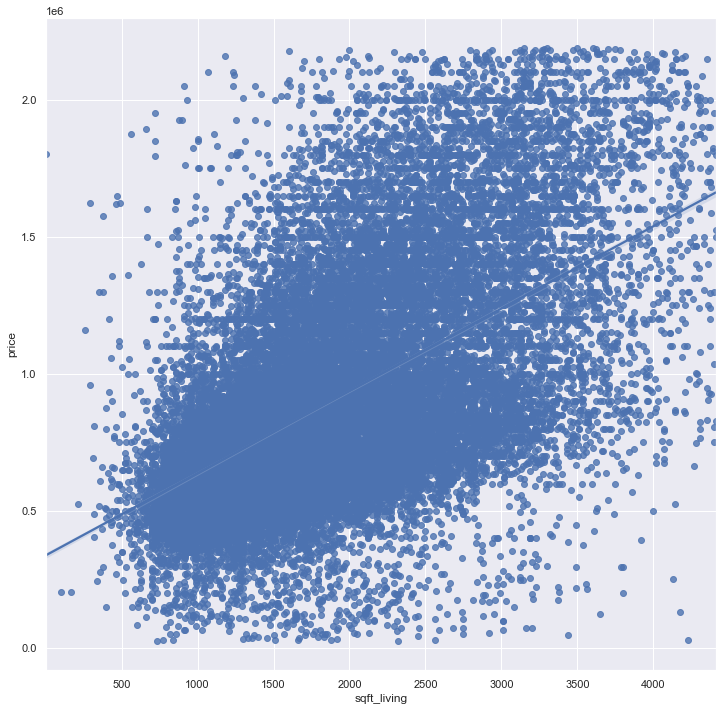

In [47]:
sns.regplot(data=df_nonscaled, x='sqft_living', y='price')

In [48]:
#pairplot with continuous variables
#commented out for run-time

#|||

# sns.pairplot(pd.concat([y, X_cat], axis=1))

## Regression Model Assumptions

### Checking Assumptions - Linearity

In [49]:
x.head()

,const,sqft_living,age_when_sold
0,1.0,1180,53
1,1.0,2770,71
2,1.0,2880,65
3,1.0,2160,11
4,1.0,1120,9


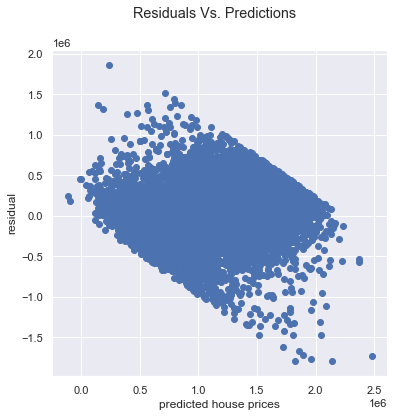

In [50]:
# plotting residuals vs predictions
model_preds = scaled_oheall_model.predict(X_cat)
resids = y - model_preds

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(model_preds, resids)

ax.set_xlabel('predicted house prices')
ax.set_ylabel('residual')
plt.suptitle('Residuals Vs. Predictions');


From our plot, we can gather that the relationship between our target and our predictors is linear.

### Checking Assumptions - Independence

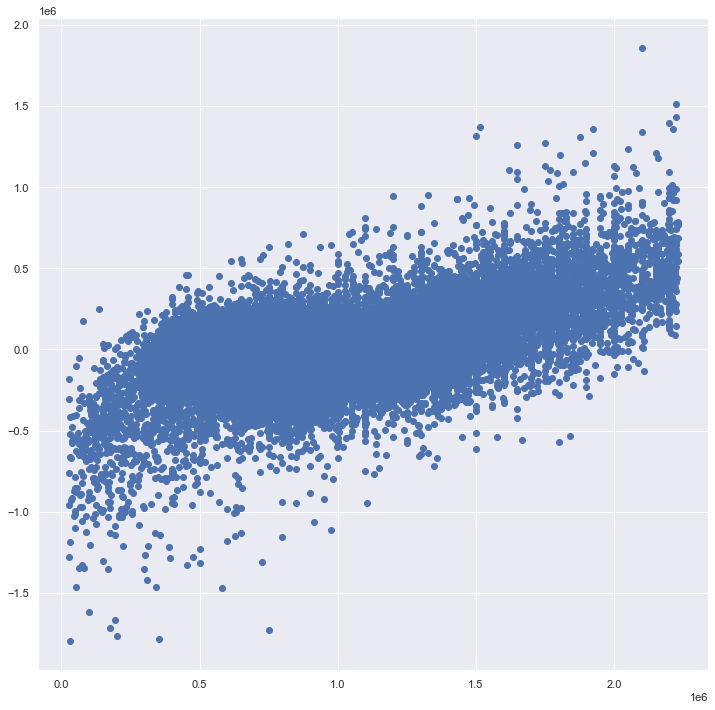

In [51]:
# plotting residuals and target value against each other to look for patterns
fig, ax = plt.subplots()

ax.scatter(y, resids);

The upwards trend in this plot suggests a very slight positive correlation in our errors.  
We can confirm by looking at the Durbin-Watson test statistic from our model.

In [52]:
durbin_watson(scaled_oheall_model.resid)

1.9740273780962416

This confirms the qualitative conclusion we drew from our scatter plot.  
Since the test statistic is below 2.0, we know there to be a very slight positive correlation in our errors.  
However, since our test statistic is so close to 2.0, we can confidently say that autocorrelation is not a problem for our regression model.

### Checking Assumptions - Normality

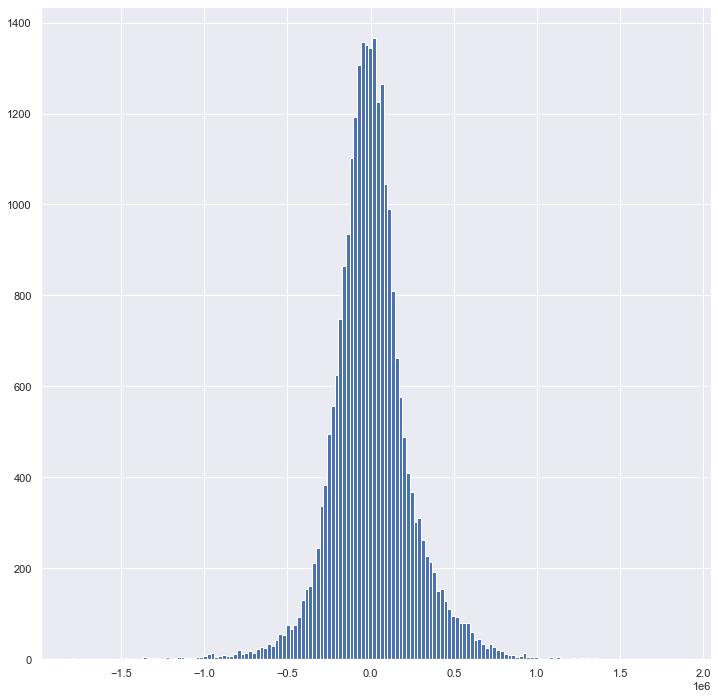

In [53]:
# Making a histogram out of our residuals
resids.hist(bins=int(np.sqrt(len(resids))));

Upon first glance at our histogram of residuals, our errors appear to be normally distributed.

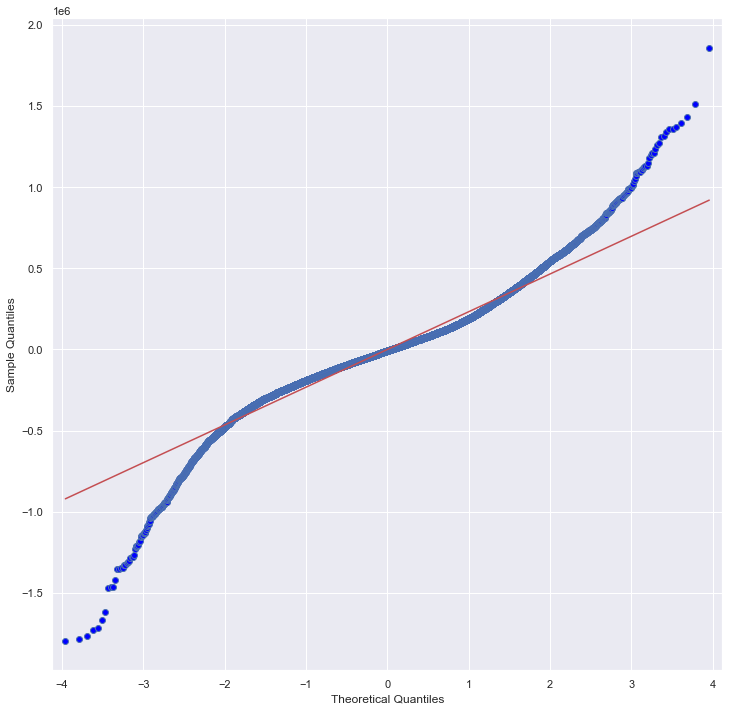

In [54]:
# Making a qqplot out of our residuals to further investigate
sm.qqplot(resids, line='r');

With normally distributed errors, our plot should follow the diagonal line closely.  
Instead, we see some fairly significant divergences at the extremes. This suggests that our errors may not follow a normal distribution.

In [55]:
# For more quantitative assessment of error distribution, we turn to the Jarque-Bera test:
jarque_bera(resids)

Jarque_beraResult(statistic=18351.139570174026, pvalue=0.0)

Based on the large magnitude of our test statistic and a P-value smaller than an alpha of 0.05, we must reject the null hypothesis that our errors are normally distributed.

Given more time, we could make individual histograms for each of our variables to see their distribution, as a non-normal distribution of errors is often caused by a non-normal distribution of variables. If we were to identify specific variables with non-normal distributions, we could try to transform the offending variables in some way to compensate. Another option would be to engineer new features based on our variables using Polynomial Features, in hopes of creating features with more normal distributions that still have a significant correlation with our target.

### Checking Assumptions - Homoscedasticity

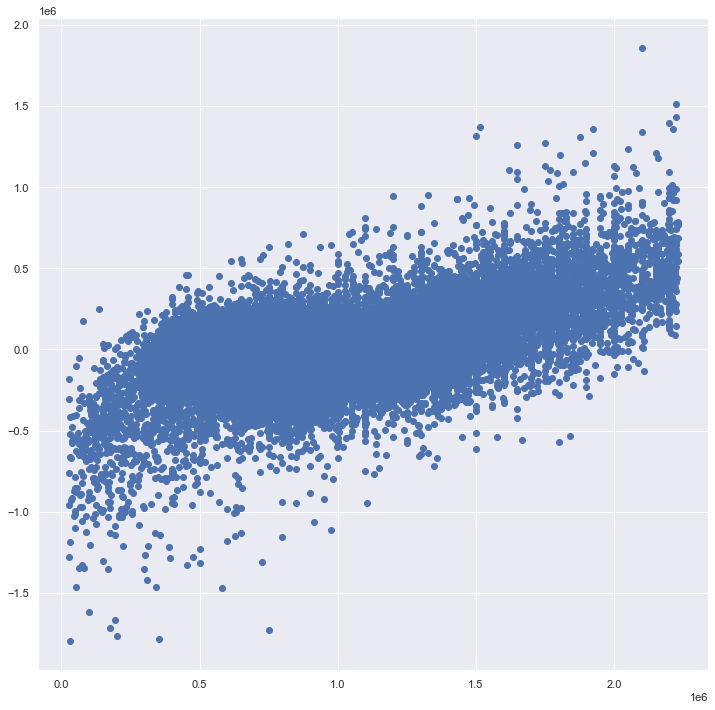

In [56]:
# We reproduce the plot from above, when we checked for independence of errors:

fig, ax = plt.subplots()

ax.scatter(y, resids);

At first glance, our errors appear to have similar variances. This is to say, the spread of our errors does not appear to vary much as our target increases. If anything, the spread may constrain slightly as our target increases, denoted by the larger presence of outliers around the smallest values of our target.

In [57]:
# For a more quantitative assessment of homoscedasticity, we employ the Goldfeld-Quant test:
sm.stats.diagnostic.het_goldfeldquandt(y,X_cat,drop=0.2)
# We chose to remove 20% of our total observations for the test, a common-practice proportion
# according to multiple online resources that were consulted.

(1.0218023963413203, 0.14345733771876557, 'increasing')

The Goldfeld-Quant test has a null hypothesis that homoscedasticity is present in our errors. Since the p-value for our test is greater than an alpha of 0.05, we fail to reject the null hypothesis and cannot gather that heteroscedasticity is a problem with our model.

In [58]:
# Turning to the Breusch-Pagan test for a second opinion on whether our data is homoscedastic:
names = ['Lagrange multiplier statistic', 'p-value',
         'f-value', 'f p-value']
bp_test_result = sm.stats.diagnostic.het_breuschpagan(scaled_oheall_model.resid, scaled_oheall_model.model.exog)
lzip(names, bp_test_result)

[('Lagrange multiplier statistic', 1974.4663711504156),
 ('p-value', 0.0),
 ('f-value', 20.63634939207755),
 ('f p-value', 0.0)]

Since our p-value is smaller than our alpha of 0.05 and our test statistic is quite high for our number of predictors, we must reject the null hypothesis and conclude that there is some evidence to suggest that our errors are heteroscedastic. 

A possible solution would be to transform our target variable in some way, such as log-scaling. However, as seen below, log-scaling our target variable makes its distribution less normal than it is currently.

Text(0.5, 1.0, 'non-scaled target')

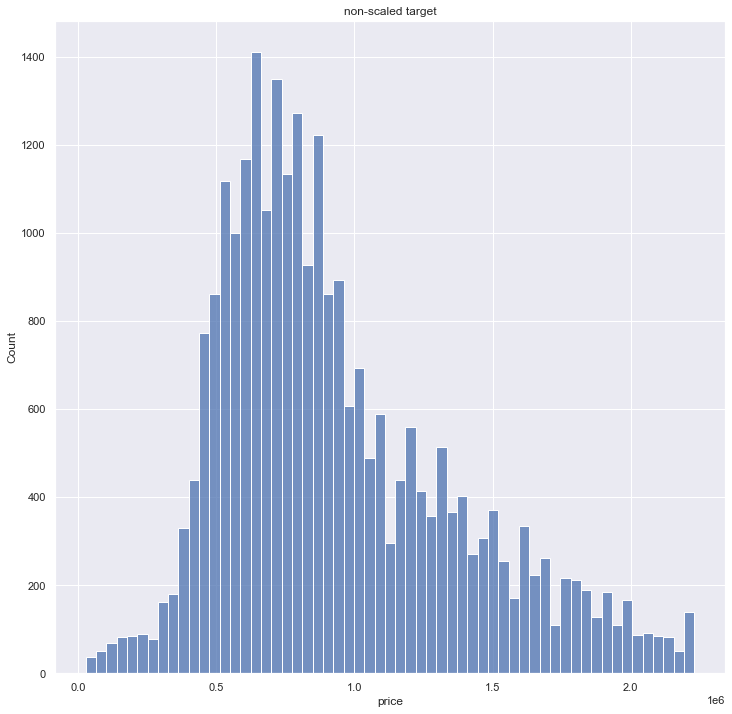

In [59]:
sns.histplot(y).set_title('non-scaled target')

Text(0.5, 1.0, 'log-scaled target')

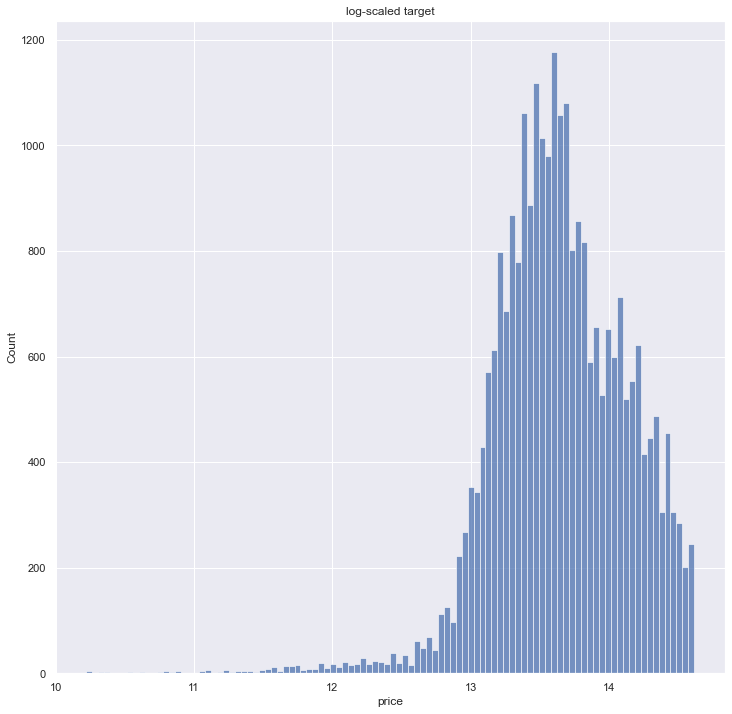

In [60]:
sns.histplot(np.log(y)).set_title('log-scaled target')

Although our target presently has a slight right skew, log-scaling it skews its distribution to the left too far to adequately account for any heteroscedasticity in our errors. Given more time, we could test other transformations of our target to try and account for the skew in its distribution.

### Checking Assumptions - Independence of Predictors (No Multicollinearity)

In [61]:
# Pulling out our model's condition number to tease out multicollinearity:
scaled_oheall_model.condition_number

490577.23677665746

Our current model's condition number is well above the generally accepted 'danger zone' of approximately 1000. We can gather from this that our predictors have a significant amount of correlation with one another, implying the presence of multicollinearity. Likely, this has to do with the large number of predictors used in our model. A logical improvement given more time is to try and cut down the number of predictor variables used and optimizing our model's R-squared score with its condition number.

# Baseline OLS Model - v2 
**Trying a new baseline model to get better model statistics.**
- only comparing sqft_foot living vs target of price

**Adding new mapper functions to parse out some df columns**

In [62]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import stats as stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import jarque_bera
from statsmodels.compat import lzip

def drop_outliers(df, col):
    q1 = df[col].quantile(.25)
    q3 = df[col].quantile(.75)
    iqr = q3 - q1

    lower_lim = q1 - 1.5 * iqr
    upper_lim = q3 + 1.5 * iqr

    df = df.loc[ (df[col] >= lower_lim) & (df[col] <= upper_lim) ].reset_index(drop=True)
    return df

def scale_numberical_cols(df, cols_to_scale):
    df = df.copy()
    features = cols_to_scale
    autoscaler = StandardScaler()
    df[features] = autoscaler.fit_transform(df[features])
    return df

# New Mapper functions for changing df values
def mapping_addressStreet(row):
    row = row.split(",")[0]
    row = row.split(" ")
    row = " ".join(row[1:])
    return row 

def mapping_addressCity(row):
    row = row.split(",")[-3].strip()
    return row 

def mapping_is_good_city(row):
    row = row in good_cities
    return row

def mapping_is_cheap_city(row):
    row = row in cheap_cities
    return row

def mapping_hasX(row):
    if row == 0:
        row = "No"
    else:
        row = "Yes"
    return row

def mapping_hasView(row):
    if row == "NONE" or row == 'Average':
        row = "No"
    else:
        row = "Yes"
    return row

In [63]:
# lets start from new baseline and play around with some new ideas on features 

df = pd.read_csv('data/kc_house_data.csv')

df = drop_outliers(df, 'sqft_living').reset_index(drop=True)
df = drop_outliers(df, 'price').reset_index(drop=True)
df = df.dropna().reset_index(drop=True)


df['date_year'] = df['date'].apply(pd.to_datetime)
df['date_year'] = df['date_year'].dt.year
df['date_year']
df['age_when_sold'] = df['date_year'] - df['yr_built']
df = drop_outliers(df, 'age_when_sold').reset_index(drop=True)

# Continuous numbers
#df['sqft_living']
df['sqft_lot_less_living'] = df['sqft_lot'] - (df['sqft_living']/df['floors'])

# Nominal categories
df['zipcode'] = df.address.str[-20:-15]
df['has_garage'] = df['sqft_garage'].map(mapping_hasX)
df['has_patio'] = df['sqft_patio'].map(mapping_hasX)
df['has_basement'] = df['sqft_basement'].map(mapping_hasX)
df['was_renovated'] = df['yr_renovated'].map(mapping_hasX)
df['has_view'] = df['view'].map(mapping_hasView)

df['waterfront']
df['street'] = df['address'].map(mapping_addressStreet)
df['city'] = df['address'].map(mapping_addressCity)
good_cities = ['Algona', 'Auburn', 'Beaux Arts Village', 'Bellevue', 
 'Black Diamond', 'Bothell', 'Burien', 'Carnation', 'Clyde Hill', 
 'Covington', 'Des Moines', 'Duvall', 'Enumclaw', 'Federal Way', 
 'Hunts Point', 'Issaquah', 'Kenmore', 'Kent', 'Kirkland', 
 'Lake Forest Park', 'Maple Valley', 'Medina', 'Mercer Island', 'Milton', 
 'Newcastle', 'Normandy Park', 'North Bend', 'Pacific', 'Redmond', 
 'Renton', 'Sammamish', 'SeaTac', 'Seattle', 'Shoreline', 'Skykomish', 
 'Snoqualmie', 'Tukwila', 'Woodinville', 'Yarrow Point']
df['good_city'] = df['city'].map(mapping_is_good_city)
df = df.loc[df['good_city'] == True].reset_index(drop=True)
# Ordinal categories
df['grade']

# Scale the continous number features
df = scale_numberical_cols(df, ['sqft_living', 'age_when_sold', 'sqft_lot_less_living'])

# Baseline
x = sm.add_constant(df[['sqft_living']])
y = df['price']
model = sm.OLS(y, x).fit()

s = model.summary()
print("r sqr:", model.rsquared)
s.tables[2]

r sqr: 0.2959834855377248


Omnibus:,1184.396,Durbin-Watson:,2.008
Prob(Omnibus):,0.000,Jarque-Bera (JB):,1381.055
Skew:,0.513,Prob(JB):,1.28e-300
Kurtosis:,3.446,Cond. No.,1.00


**New Features**

In [64]:
df['view'].value_counts()

NONE         23943
AVERAGE       1556
GOOD           599
EXCELLENT      221
FAIR           164
Name: view, dtype: int64

**Make sure target is normalized after scaling**

<AxesSubplot:xlabel='price', ylabel='Count'>

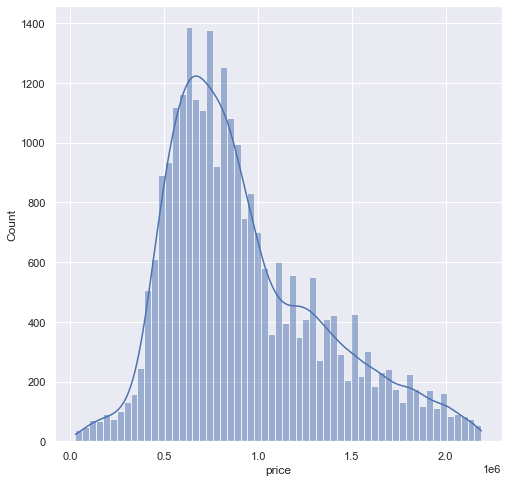

In [65]:
fig, ax = plt.subplots(figsize=(8,8))
sns.histplot(df.price, kde=True)

**Add New Feature - 'sqft_lot_less_living'**

In [66]:
x = sm.add_constant(df[['sqft_living','sqft_lot_less_living']])    
y = df['price']
model = sm.OLS(y, x).fit()

s = model.summary()
print("r sqr:", model.rsquared)
s.tables[2]

r sqr: 0.2962058300002882


Omnibus:,1174.291,Durbin-Watson:,2.008
Prob(Omnibus):,0.000,Jarque-Bera (JB):,1366.347
Skew:,0.511,Prob(JB):,2.00e-297
Kurtosis:,3.439,Cond. No.,1.08


**sqft_lot** helps out jarque bera a tiny amount

Add in 'age_when_sold' Feature

In [67]:
x = sm.add_constant(df[['sqft_living','sqft_lot_less_living', 'age_when_sold']])    
y = df['price']
model = sm.OLS(y, x).fit()

s = model.summary()
print("r sqr:", model.rsquared)
s.tables[2]


r sqr: 0.30950338776872865


Omnibus:,1061.033,Durbin-Watson:,2.005
Prob(Omnibus):,0.000,Jarque-Bera (JB):,1245.189
Skew:,0.470,Prob(JB):,4.08e-271
Kurtosis:,3.493,Cond. No.,1.43


**age_when_sold brings down Jarque-bera and omnibus**

**Try out new nominal categorical features using one hot encoder**

In [68]:
x = df[['sqft_living', 'sqft_lot_less_living','age_when_sold']]
ohe_cols = ['city']

ohe = OneHotEncoder(drop='first')
ohe.fit(df[ohe_cols])
ohe_all = pd.DataFrame(ohe.transform(df[ohe_cols]).todense(),columns=ohe.get_feature_names())
X_cat = pd.concat([x,ohe_all], axis=1)
model = sm.OLS(y, sm.add_constant(X_cat)).fit()

s = model.summary()
print("r sqr:", model.rsquared)
s.tables[2]

r sqr: 0.6079013023338673


Omnibus:,1595.089,Durbin-Watson:,1.987
Prob(Omnibus):,0.000,Jarque-Bera (JB):,6617.238
Skew:,0.134,Prob(JB):,0.00
Kurtosis:,5.434,Cond. No.,199.


**This worked out well. This is the new model to beat.**

**Try other features**

In [69]:
x = df[['sqft_living', 'sqft_lot_less_living','age_when_sold']]
ohe_cols = ['city','waterfront', 'has_basement', 'has_garage', 'has_patio']

ohe = OneHotEncoder(drop='first')
ohe.fit(df[ohe_cols])
ohe_all = pd.DataFrame(ohe.transform(df[ohe_cols]).todense(),columns=ohe.get_feature_names())
X_cat = pd.concat([x,ohe_all], axis=1)
model = sm.OLS(y, sm.add_constant(X_cat)).fit()

s = model.summary()
print("r sqr:", model.rsquared)
s.tables[2]

r sqr: 0.6136948618237787


Omnibus:,1592.517,Durbin-Watson:,1.989
Prob(Omnibus):,0.000,Jarque-Bera (JB):,6767.909
Skew:,0.112,Prob(JB):,0.00
Kurtosis:,5.466,Cond. No.,267.


**Try layering in a Ordinal Categorical variable (Grade)**

In [70]:
# ordinally encoding grade
grade_df = df[['grade']]
grade_cats = [['2 Substandard',
               '3 Poor',
               '4 Low',
               '5 Fair',
               '6 Low Average',
               '7 Average',
               '8 Good',
               '9 Better',
               '10 Very Good',
               '11 Excellent',
               '12 Luxury',
               '13 Mansion']]
ords_grade = OrdinalEncoder(categories=grade_cats)
ords_grade.fit(grade_df)
ords_grade.transform(grade_df)
grades_encoded = pd.DataFrame(ords_grade.transform(grade_df))


x=df[['sqft_living', 'sqft_lot_less_living', 'age_when_sold']]
ohe_cols = ['city','waterfront', 'has_basement', 'has_garage', 'has_patio']
ohe = OneHotEncoder(drop='first')

ohe.fit(df[ohe_cols])
ohe_all = pd.DataFrame(ohe.transform(df[ohe_cols]).todense(),
                            columns=ohe.get_feature_names())

X_cat = pd.concat([x,ohe_all,grades_encoded], axis=1)
model = sm.OLS(y, sm.add_constant(X_cat)).fit()

s = model.summary()
print("r sqr:", model.rsquared)
s.tables[2]

r sqr: 0.6425970477834806


Omnibus:,1812.010,Durbin-Watson:,1.992
Prob(Omnibus):,0.000,Jarque-Bera (JB):,9065.390
Skew:,0.077,Prob(JB):,0.00
Kurtosis:,5.862,Cond. No.,972.


**This skyrockets our JB and our cond no. Not using Grade.**  

**Now try Condition**

In [71]:
# ordinally encoding condition
cond_df = df[['condition']]
cond_cats = [['Poor',
              'Fair',
              'Average',
              'Good',
              'Very Good']]
ords_cond = OrdinalEncoder(categories=cond_cats)
ords_cond.fit(cond_df)
ords_cond.transform(cond_df)
cond_encoded = pd.DataFrame(ords_cond.transform(cond_df))
cond_encoded

x=df[['sqft_living', 'sqft_lot_less_living', 'age_when_sold']]
ohe_cols = ['city','waterfront', 'has_basement', 'has_garage', 'has_patio']
ohe = OneHotEncoder(drop='first')

ohe.fit(df[ohe_cols])
ohe_all = pd.DataFrame(ohe.transform(df[ohe_cols]).todense(),
                            columns=ohe.get_feature_names())

X_cat = pd.concat([x,ohe_all,cond_encoded], axis=1)
model = sm.OLS(y, sm.add_constant(X_cat)).fit()

s = model.summary()
print("r sqr:", model.rsquared)
s.tables[2]

r sqr: 0.6181849914289587


Omnibus:,1676.908,Durbin-Watson:,1.986
Prob(Omnibus):,0.000,Jarque-Bera (JB):,7310.904
Skew:,0.135,Prob(JB):,0.00
Kurtosis:,5.560,Cond. No.,505.


In [72]:
# ordinally encoding condition
cond_df = df[['condition']]
cond_cats = [['Poor',
              'Fair',
              'Average',
              'Good',
              'Very Good']]
ords_cond = OrdinalEncoder(categories=cond_cats)
ords_cond.fit(cond_df)
ords_cond.transform(cond_df)
cond_encoded = pd.DataFrame(ords_cond.transform(cond_df))
cond_encoded

x=df[['sqft_living', 'sqft_lot_less_living', 'age_when_sold']]
ohe_cols = ['city','waterfront', 'has_basement', 'has_garage', 'has_patio']
ohe = OneHotEncoder(drop='first')

ohe.fit(df[ohe_cols])
ohe_all = pd.DataFrame(ohe.transform(df[ohe_cols]).todense(),
                            columns=ohe.get_feature_names())

X_cat = pd.concat([x,ohe_all,cond_encoded], axis=1)
model = sm.OLS(y, sm.add_constant(X_cat)).fit()

s = model.summary()
print("r sqr:", model.rsquared)
s.tables[2]

r sqr: 0.6181849914289587


Omnibus:,1676.908,Durbin-Watson:,1.986
Prob(Omnibus):,0.000,Jarque-Bera (JB):,7310.904
Skew:,0.135,Prob(JB):,0.00
Kurtosis:,5.560,Cond. No.,505.


**This hurt our condition no.

**Trying a couple more features - Starting from Model A**

In [73]:
x = df[['sqft_living', 'sqft_lot_less_living', 'age_when_sold']]
ohe_cols = ['city','waterfront', 'has_basement', 'has_garage', 'has_patio','was_renovated']

ohe = OneHotEncoder(drop='first')
ohe.fit(df[ohe_cols])
ohe_all = pd.DataFrame(ohe.transform(df[ohe_cols]).todense(),columns=ohe.get_feature_names())
X_cat = pd.concat([x,ohe_all], axis=1)
model = sm.OLS(y, sm.add_constant(X_cat)).fit()

s = model.summary();
print("R sqr:", model.rsquared)
s.tables[2]

R sqr: 0.6140667984387345


Omnibus:,1591.014,Durbin-Watson:,1.989
Prob(Omnibus):,0.000,Jarque-Bera (JB):,6774.010
Skew:,0.110,Prob(JB):,0.00
Kurtosis:,5.468,Cond. No.,267.


**Didn't do much for us.  Try a few more**

**Try all new and available nomimal categories**

In [74]:
x = df[['sqft_living', 'sqft_lot_less_living','age_when_sold']]
ohe_cols = ['city','waterfront', 'has_basement', 'has_garage', 'has_patio','greenbelt', 'nuisance', 'has_view']

ohe = OneHotEncoder(drop='first')
ohe.fit(df[ohe_cols])
ohe_all = pd.DataFrame(ohe.transform(df[ohe_cols]).todense(),columns=ohe.get_feature_names())
X_cat = pd.concat([x,ohe_all], axis=1)
model = sm.OLS(y, sm.add_constant(X_cat)).fit()

s = model.summary()
print("R sqr:", model.rsquared)
s.tables[2]

R sqr: 0.6214558432033553


Omnibus:,1597.366,Durbin-Watson:,1.989
Prob(Omnibus):,0.000,Jarque-Bera (JB):,7039.655
Skew:,0.075,Prob(JB):,0.00
Kurtosis:,5.521,Cond. No.,269.


In [75]:
s

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     943.5
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:18:45   Log-Likelihood:            -3.6751e+05
No. Observations:               26483   AIC:                         7.351e+05
Df Residuals:                   26436   BIC:                         7.355e+05
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.314e+05   3.67e+04     14.466      0.000    4.59e+05    6.03e+05
sqft_living           2.121e+05   1872.623    113.260      0.000    2.08e+05    2.16e+05
sqft_lot_less_living  2.141e+04   1650.553     12.970      0.000    1.82e+04    2.46e+04
age_when_sold         3.077e+04   2013.570     15.279      0.000    2.68e+04    3.47e+04
x0_Auburn             2.623e+04   3.71e+04      0.707      0.479   -4.64e+04    9.89e+04
x0_Bellevue           7.513e+05   3.73e+04     20.122      0.000    6.78e+05    8.24e+05
x0_Black Diamond      7.436e+04   3.97e+04      1.871      0.061   -3534.543    1.52e+05
x0_Bothell            5.009e+05      4e+04     12.534      0.000    4.23e+05    5.79e+05
x0_Burien             1.674e+05    3.8e+04      4.407      0.000    9.29e+04    2.42e+05
x0_Carnation          2.446e+05   4.22e+04      5.790      0.000    1.62e+05    3.27e+05
x0_Clyde Hill         1.594e+06   1.86e+05      8.580      0.000    1.23e+06    1.96e+06
x0_Covington          6.033e+04   3.83e+04      1.577      0.115   -1.47e+04    1.35e+05
x0_Des Moines         8.001e+04   3.86e+04      2.074      0.038    4391.903    1.56e+05
x0_Duvall             2.908e+05   4.01e+04      7.254      0.000    2.12e+05    3.69e+05
x0_Enumclaw           2.432e+04   3.85e+04      0.632      0.527   -5.11e+04    9.98e+04
x0_Federal Way        1.423e+04   3.73e+04      0.382      0.702   -5.88e+04    8.73e+04
x0_Issaquah           5.926e+05   3.83e+04     15.459      0.000    5.17e+05    6.68e+05
x0_Kenmore            4.149e+05   3.91e+04     10.621      0.000    3.38e+05    4.91e+05
x0_Kent               5.268e+04   3.71e+04      1.422      0.155   -1.99e+04    1.25e+05
x0_Kirkland           6.864e+05   3.74e+04     18.370      0.000    6.13e+05     7.6e+05
x0_Lake Forest Park   4.278e+05   4.06e+04     10.537      0.000    3.48e+05    5.07e+05
x0_Maple Valley       1.467e+05   3.75e+04      3.910      0.000    7.32e+04     2.2e+05
x0_Medina             1.241e+06   1.86e+05      6.680      0.000    8.77e+05    1.61e+06
x0_Mercer Island      9.417e+05   4.22e+04     22.335      0.000    8.59e+05    1.02e+06
x0_Milton             5.679e+04   6.23e+04      0.911      0.362   -6.54e+04    1.79e+05
x0_Newcastle          6.022e+05   4.17e+04     14.431      0.000     5.2e+05    6.84e+05
x0_Normandy Park      2.416e+05   4.41e+04      5.475      0.000    1.55e+05    3.28e+05
x0_North Bend         3.055e+05   3.85e+04      7.941      0.000     2.3e+05    3.81e+05
x0_Pacific            2.712e+04   4.68e+04      0.579      0.562   -6.46e+04    1.19e+05
x0_Redmond            6.956e+05   3.76e+04     18.506      0.000    6.22e+05    7.69e+05
x0_Renton             1.904e+05   3.69e+04      5.152      0.000    1.18e+05    2.63e+05
x0_Sammamish          7.487e+05   3.77e+04     19.856    

**This looks like the best one.**

# Regression Model Assumptions v2

### Checking Assumptions - New Model

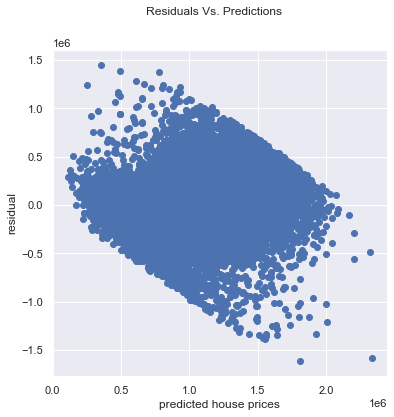

In [76]:
# plotting residuals vs predictions
model_preds = model.predict(sm.add_constant(X_cat))
resids = y - model_preds

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(model_preds, resids)

ax.set_xlabel('predicted house prices')
ax.set_ylabel('residual')
plt.suptitle('Residuals Vs. Predictions');


From our plot, we can gather that the relationship between our target and our predictors is linear.

### Checking Assumptions - Independence

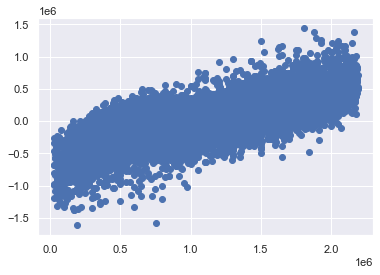

In [77]:
# plotting residuals and target value against each other to look for patterns
fig, ax = plt.subplots()

ax.scatter(y, resids);

The upwards trend in this plot suggests a very slight positive correlation in our errors.  
We can confirm by looking at the Durbin-Watson test statistic from our model.

In [78]:
durbin_watson(model.resid)

1.9885919167316604

This confirms the qualitative conclusion we drew from our scatter plot.  
Since the test statistic is below 2.0, we know there to be a very slight positive correlation in our errors.  
However, since our test statistic is so close to 2.0, we can confidently say that autocorrelation is not a problem for our regression model.

### Checking Assumptions - Normality

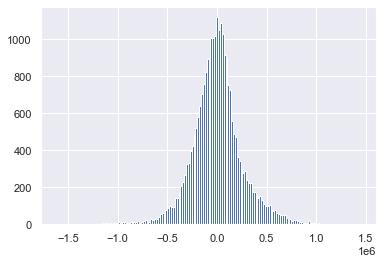

In [79]:
# Making a histogram out of our residuals
resids.hist(bins=int(np.sqrt(len(resids))));

Upon first glance at our histogram of residuals, our errors appear to be normally distributed.

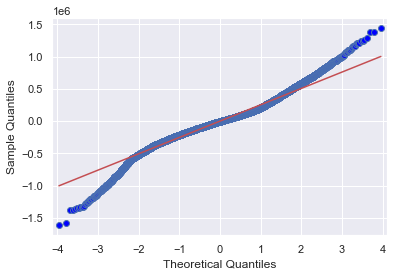

In [80]:
# Making a qqplot out of our residuals to further investigate
sm.qqplot(resids, line='r');

With normally distributed errors, our plot should follow the diagonal line closely.  
Instead, we see some fairly significant divergences at the extremes. This suggests that our errors may not follow a normal distribution.

In [81]:
# For more quantitative assessment of error distribution, we turn to the Jarque-Bera test:
jarque_bera(resids)

Jarque_beraResult(statistic=7039.654966167089, pvalue=0.0)

Based on the large magnitude of our test statistic and a P-value smaller than an alpha of 0.05, we must reject the null hypothesis that our errors are normally distributed.

Given more time, we could make individual histograms for each of our variables to see their distribution, as a non-normal distribution of errors is often caused by a non-normal distribution of variables. If we were to identify specific variables with non-normal distributions, we could try to transform the offending variables in some way to compensate. Another option would be to engineer new features based on our variables using Polynomial Features, in hopes of creating features with more normal distributions that still have a significant correlation with our target.

### Checking Assumptions - Homoscedasticity

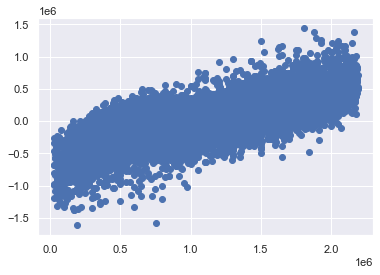

In [82]:
# We reproduce the plot from above, when we checked for independence of errors:

fig, ax = plt.subplots()

ax.scatter(y, resids);

At first glance, our errors appear to have similar variances. This is to say, the spread of our errors does not appear to vary much as our target increases. If anything, the spread may constrain slightly as our target increases, denoted by the larger presence of outliers around the smallest values of our target.

In [83]:
# For a more quantitative assessment of homoscedasticity, we employ the Goldfeld-Quant test:
sm.stats.diagnostic.het_goldfeldquandt(y,sm.add_constant(X_cat),drop=0.2)
# We chose to remove 20% of our total observations for the test, a common-practice proportion
# according to multiple online resources that were consulted.

(0.9874786620366286, 0.7351101602688859, 'increasing')

The Goldfeld-Quant test has a null hypothesis that homoscedasticity is present in our errors. Since the p-value for our test is greater than an alpha of 0.05, we fail to reject the null hypothesis and cannot gather that heteroscedasticity is a problem with our model.

In [84]:
# Turning to the Breusch-Pagan test for a second opinion on whether our data is homoscedastic:
names = ['Lagrange multiplier statistic', 'p-value',
         'f-value', 'f p-value']
bp_test_result = sm.stats.diagnostic.het_breuschpagan(model.resid, model.model.exog)
lzip(names, bp_test_result)

[('Lagrange multiplier statistic', 2279.3581669918062),
 ('p-value', 0.0),
 ('f-value', 54.12149284620623),
 ('f p-value', 0.0)]

Since our p-value is smaller than our alpha of 0.05 and our test statistic is quite high for our number of predictors, we must reject the null hypothesis and conclude that there is some evidence to suggest that our errors are heteroscedastic. 

A possible solution would be to transform our target variable in some way, such as log-scaling. However, as seen below, log-scaling our target variable makes its distribution less normal than it is currently.

Text(0.5, 1.0, 'non-scaled target')

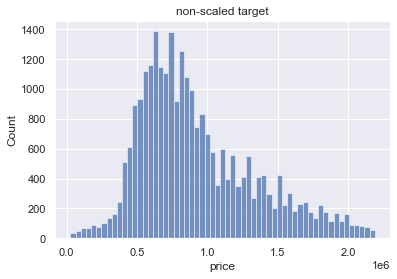

In [85]:
sns.histplot(y).set_title('non-scaled target')

Text(0.5, 1.0, 'log-scaled target')

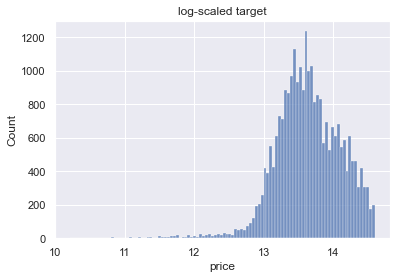

In [86]:
sns.histplot(np.log(y)).set_title('log-scaled target')

Although our target presently has a slight right skew, log-scaling it skews its distribution to the left too far to adequately account for any heteroscedasticity in our errors. Given more time, we could test other transformations of our target to try and account for the skew in its distribution.

### Checking Assumptions - Independence of Predictors (No Multicollinearity)

In [87]:
# Pulling out our model's condition number to tease out multicollinearity:
model.condition_number

269.39234338796416

Our current model's condition number is well above the generally accepted 'danger zone' of approximately 1000. We can gather from this that our predictors have a significant amount of correlation with one another, implying the presence of multicollinearity. Likely, this has to do with the large number of predictors used in our model. A logical improvement given more time is to try and cut down the number of predictor variables used and optimizing our model's R-squared score with its condition number.

In [88]:
s

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     943.5
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:18:45   Log-Likelihood:            -3.6751e+05
No. Observations:               26483   AIC:                         7.351e+05
Df Residuals:                   26436   BIC:                         7.355e+05
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.314e+05   3.67e+04     14.466      0.000    4.59e+05    6.03e+05
sqft_living           2.121e+05   1872.623    113.260      0.000    2.08e+05    2.16e+05
sqft_lot_less_living  2.141e+04   1650.553     12.970      0.000    1.82e+04    2.46e+04
age_when_sold         3.077e+04   2013.570     15.279      0.000    2.68e+04    3.47e+04
x0_Auburn             2.623e+04   3.71e+04      0.707      0.479   -4.64e+04    9.89e+04
x0_Bellevue           7.513e+05   3.73e+04     20.122      0.000    6.78e+05    8.24e+05
x0_Black Diamond      7.436e+04   3.97e+04      1.871      0.061   -3534.543    1.52e+05
x0_Bothell            5.009e+05      4e+04     12.534      0.000    4.23e+05    5.79e+05
x0_Burien             1.674e+05    3.8e+04      4.407      0.000    9.29e+04    2.42e+05
x0_Carnation          2.446e+05   4.22e+04      5.790      0.000    1.62e+05    3.27e+05
x0_Clyde Hill         1.594e+06   1.86e+05      8.580      0.000    1.23e+06    1.96e+06
x0_Covington          6.033e+04   3.83e+04      1.577      0.115   -1.47e+04    1.35e+05
x0_Des Moines         8.001e+04   3.86e+04      2.074      0.038    4391.903    1.56e+05
x0_Duvall             2.908e+05   4.01e+04      7.254      0.000    2.12e+05    3.69e+05
x0_Enumclaw           2.432e+04   3.85e+04      0.632      0.527   -5.11e+04    9.98e+04
x0_Federal Way        1.423e+04   3.73e+04      0.382      0.702   -5.88e+04    8.73e+04
x0_Issaquah           5.926e+05   3.83e+04     15.459      0.000    5.17e+05    6.68e+05
x0_Kenmore            4.149e+05   3.91e+04     10.621      0.000    3.38e+05    4.91e+05
x0_Kent               5.268e+04   3.71e+04      1.422      0.155   -1.99e+04    1.25e+05
x0_Kirkland           6.864e+05   3.74e+04     18.370      0.000    6.13e+05     7.6e+05
x0_Lake Forest Park   4.278e+05   4.06e+04     10.537      0.000    3.48e+05    5.07e+05
x0_Maple Valley       1.467e+05   3.75e+04      3.910      0.000    7.32e+04     2.2e+05
x0_Medina             1.241e+06   1.86e+05      6.680      0.000    8.77e+05    1.61e+06
x0_Mercer Island      9.417e+05   4.22e+04     22.335      0.000    8.59e+05    1.02e+06
x0_Milton             5.679e+04   6.23e+04      0.911      0.362   -6.54e+04    1.79e+05
x0_Newcastle          6.022e+05   4.17e+04     14.431      0.000     5.2e+05    6.84e+05
x0_Normandy Park      2.416e+05   4.41e+04      5.475      0.000    1.55e+05    3.28e+05
x0_North Bend         3.055e+05   3.85e+04      7.941      0.000     2.3e+05    3.81e+05
x0_Pacific            2.712e+04   4.68e+04      0.579      0.562   -6.46e+04    1.19e+05
x0_Redmond            6.956e+05   3.76e+04     18.506      0.000    6.22e+05    7.69e+05
x0_Renton             1.904e+05   3.69e+04      5.152      0.000    1.18e+05    2.63e+05
x0_Sammamish          7.487e+05   3.77e+04     19.856    

# Recommendations

In [89]:
d = pd.DataFrame(s.tables[1])
# new_header = d.iloc[0] #grab the first row for the header
# d = d[1:] #take the data less the header row
# d.columns = new_header
d=d.set_index(d.columns.tolist()[0])
d=d[1:]
d

,1,2,3,4,5,6
0,,,,,,
const,5.314e+05,3.67e+04,14.466,0.000,4.59e+05,6.03e+05
sqft_living,2.121e+05,1872.623,113.260,0.000,2.08e+05,2.16e+05
sqft_lot_less_living,2.141e+04,1650.553,12.970,0.000,1.82e+04,2.46e+04
age_when_sold,3.077e+04,2013.570,15.279,0.000,2.68e+04,3.47e+04
x0_Auburn,2.623e+04,3.71e+04,0.707,0.479,-4.64e+04,9.89e+04
x0_Bellevue,7.513e+05,3.73e+04,20.122,0.000,6.78e+05,8.24e+05
x0_Black Diamond,7.436e+04,3.97e+04,1.871,0.061,-3534.543,1.52e+05
x0_Bothell,5.009e+05,4e+04,12.534,0.000,4.23e+05,5.79e+05
x0_Burien,1.674e+05,3.8e+04,4.407,0.000,9.29e+04,2.42e+05


In [90]:
'''
x0   city
x1   waterfront
x2   has basement
x3   Garage
x4   Patio
x5   Green Belt 
x6   Nuisance
x7   View
'''

'\nx0   city\nx1   waterfront\nx2   has basement\nx3   Garage\nx4   Patio\nx5   Green Belt \nx6   Nuisance\nx7   View\n'

### Cheapest Cities

##### Try to buy in the following cities for lowest cost:
1. Skyomish
2. Algona
3. Federal Way
4. Enumclaw
5. Auburn

In [91]:
cheap_cities = ['Skykomish', 'Algona', 'Federal Way', 'Enumclaw', 'Auburn']

In [92]:
df['cheap_city'] = df['city'].map(mapping_is_cheap_city)

In [93]:
df_cheap = df.loc[df['cheap_city'] == True].reset_index(drop=True)
df_cheap['mean_price'] = df['price'].mean()
df_cheap.city.value_counts()

Auburn         1500
Federal Way    1150
Enumclaw        450
Algona           50
Skykomish        16
Name: city, dtype: int64

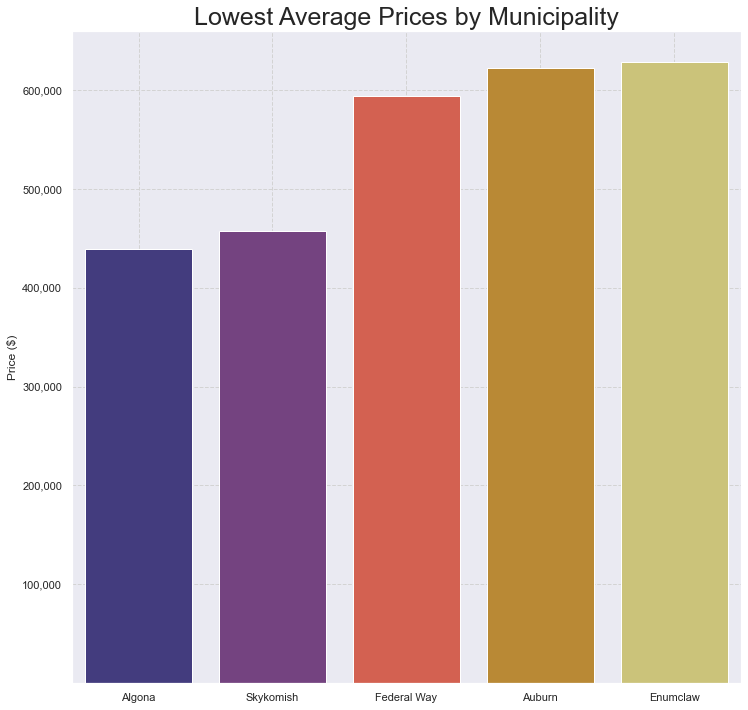

In [94]:
fig, ax = plt.subplots(figsize=(12, 12))

sns.barplot(data=df_cheap, x='city', y='price', saturation=.6, palette='CMRmap',
            order=reversed(['Enumclaw', 'Auburn', 'Federal Way', 'Skykomish', 'Algona']),
            ci=None, )

ax.set_title('Lowest Average Prices by Municipality', fontsize=25)
ax.set_xlabel('')
ax.set_ylabel('Price ($)')

ax.set_yticks([100000, 200000, 300000, 400000, 500000, 600000])
ax.set_yticklabels(['100,000', '200,000', '300,000', '400,000', '500,000', '600,000'])
ax.grid(color='lightgray', linestyle='dashed')

### Garage (x3)

According to our model, we are 95% confident that adding a garage will increase value by between 38,000 dollars and 54,000 dollars so to have the highest likelihood of turning a profit, if you can add a garage for under 38,000 dollars, then we believe you should.

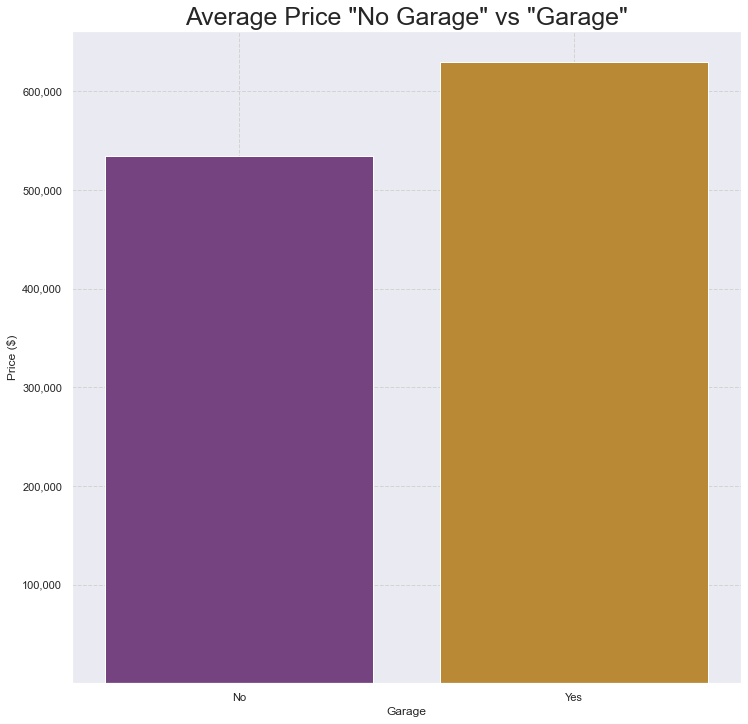

In [95]:
fig, ax = plt.subplots(figsize=(12, 12))

sns.barplot(data=df_cheap, x='has_garage', y='price',
            saturation=.6, palette='CMRmap',
            order=["No", "Yes"], ci=None)

ax.set_title('Average Price \"No Garage\" vs \"Garage\"', fontsize=25)
ax.set_xlabel('Garage')
ax.set_ylabel('Price ($)')

ax.set_yticks([100000, 200000, 300000, 400000, 500000, 600000])
ax.set_yticklabels(['100,000', '200,000', '300,000', '400,000', '500,000', '600,000'])
ax.grid(color='lightgray', linestyle='dashed')

### Patio (x4)

According to our model, we are 95% confident that adding a patio will increase value by between approximately 18,000 dollars and 33,000 dollars, so to have the highest likelihood of turning a profit, if you can add a patio for under 18,000 dollars, then we believe you should.

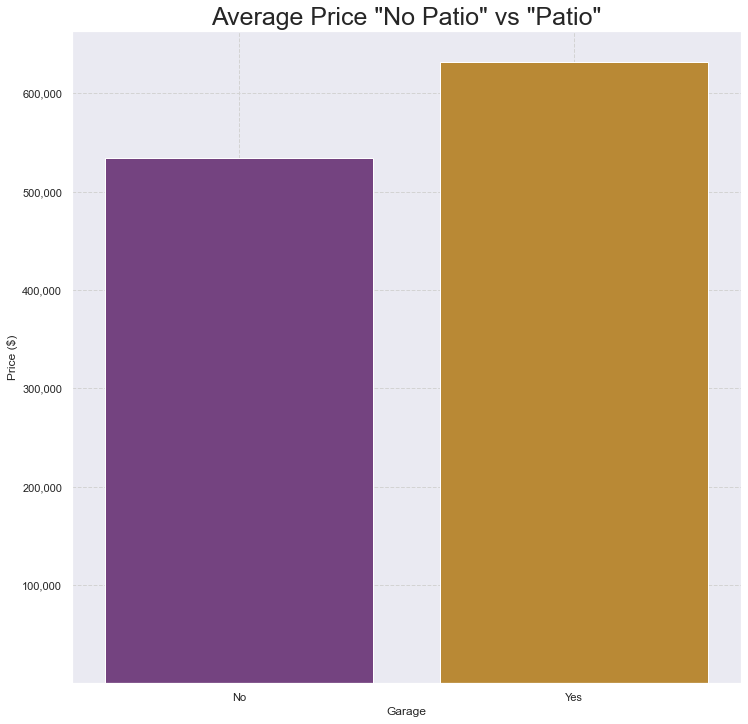

In [96]:
fig, ax = plt.subplots(figsize=(12, 12))

sns.barplot(data=df_cheap, x='has_patio', y='price',
            saturation=.6, palette='CMRmap',
            order=["No", "Yes"], ci=None)

ax.set_title('Average Price \"No Patio\" vs \"Patio\"', fontsize=25)
ax.set_xlabel('Garage')
ax.set_ylabel('Price ($)')

ax.set_yticks([100000, 200000, 300000, 400000, 500000, 600000])
ax.set_yticklabels(['100,000', '200,000', '300,000', '400,000', '500,000', '600,000'])
ax.grid(color='lightgray', linestyle='dashed')

# Conclusions
|||

# Limitations
|||

# Future Considerations
|||